In [1]:
import sqlite3
import pandas as pd
import os
import re
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.metrics import accuracy_score, roc_curve, auc,  precision_recall_curve, average_precision_score
from sklearn.grid_search import GridSearchCV
from nltk.tokenize import sent_tokenize, word_tokenize, StanfordTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import string
import seaborn as sns
sns.set_style("whitegrid")
os.chdir('/Users/RayLJazz//Dropbox/UCDavis/2016spring/STA208/Github/Data')

# Read Pickles

In [2]:
SOM = pd.read_pickle('stackoverflow_metric_df.pickle')
RM = pd.read_pickle('Readability_Metrics_wtbody.pickle')
PM = pd.read_pickle('popularity_metric.pickle')

In [3]:
query = "SELECT * FROM [posts]"
conn = sqlite3.connect('crossvalidated.db')
post_df = pd.read_sql_query(query, conn)
post_df.head()
qpost_df = post_df[post_df.PostTypeId == 1]

## Stackoverflow Metrics

In [4]:
SOM.head()

,Id,ClosedDate,Score,BodyLen,LowerCasePer,UpperCasePer,SpaceCnt,TagCnt,Sentimental_Polarity,Sentimental_Subjectivity,TitleLen,UrlCnt
0,1,None,31,91,0.958763,0.041237,15,3,0.133333,0.133333,29,0
1,2,None,26,146,0.969466,0.030534,25,2,0.000000,0.000000,18,0
2,3,None,63,206,0.963303,0.036697,36,2,0.021875,0.596875,65,0
3,4,None,15,497,0.970982,0.029018,90,2,0.129808,0.552885,58,0
5,6,None,226,1628,0.962547,0.037453,204,1,-0.150000,0.300000,50,4


In [5]:
SOM.shape

(75067, 12)

In [6]:
predictors_SOM = [x for x in SOM.columns if x not in ['ClosedDate','Score']]

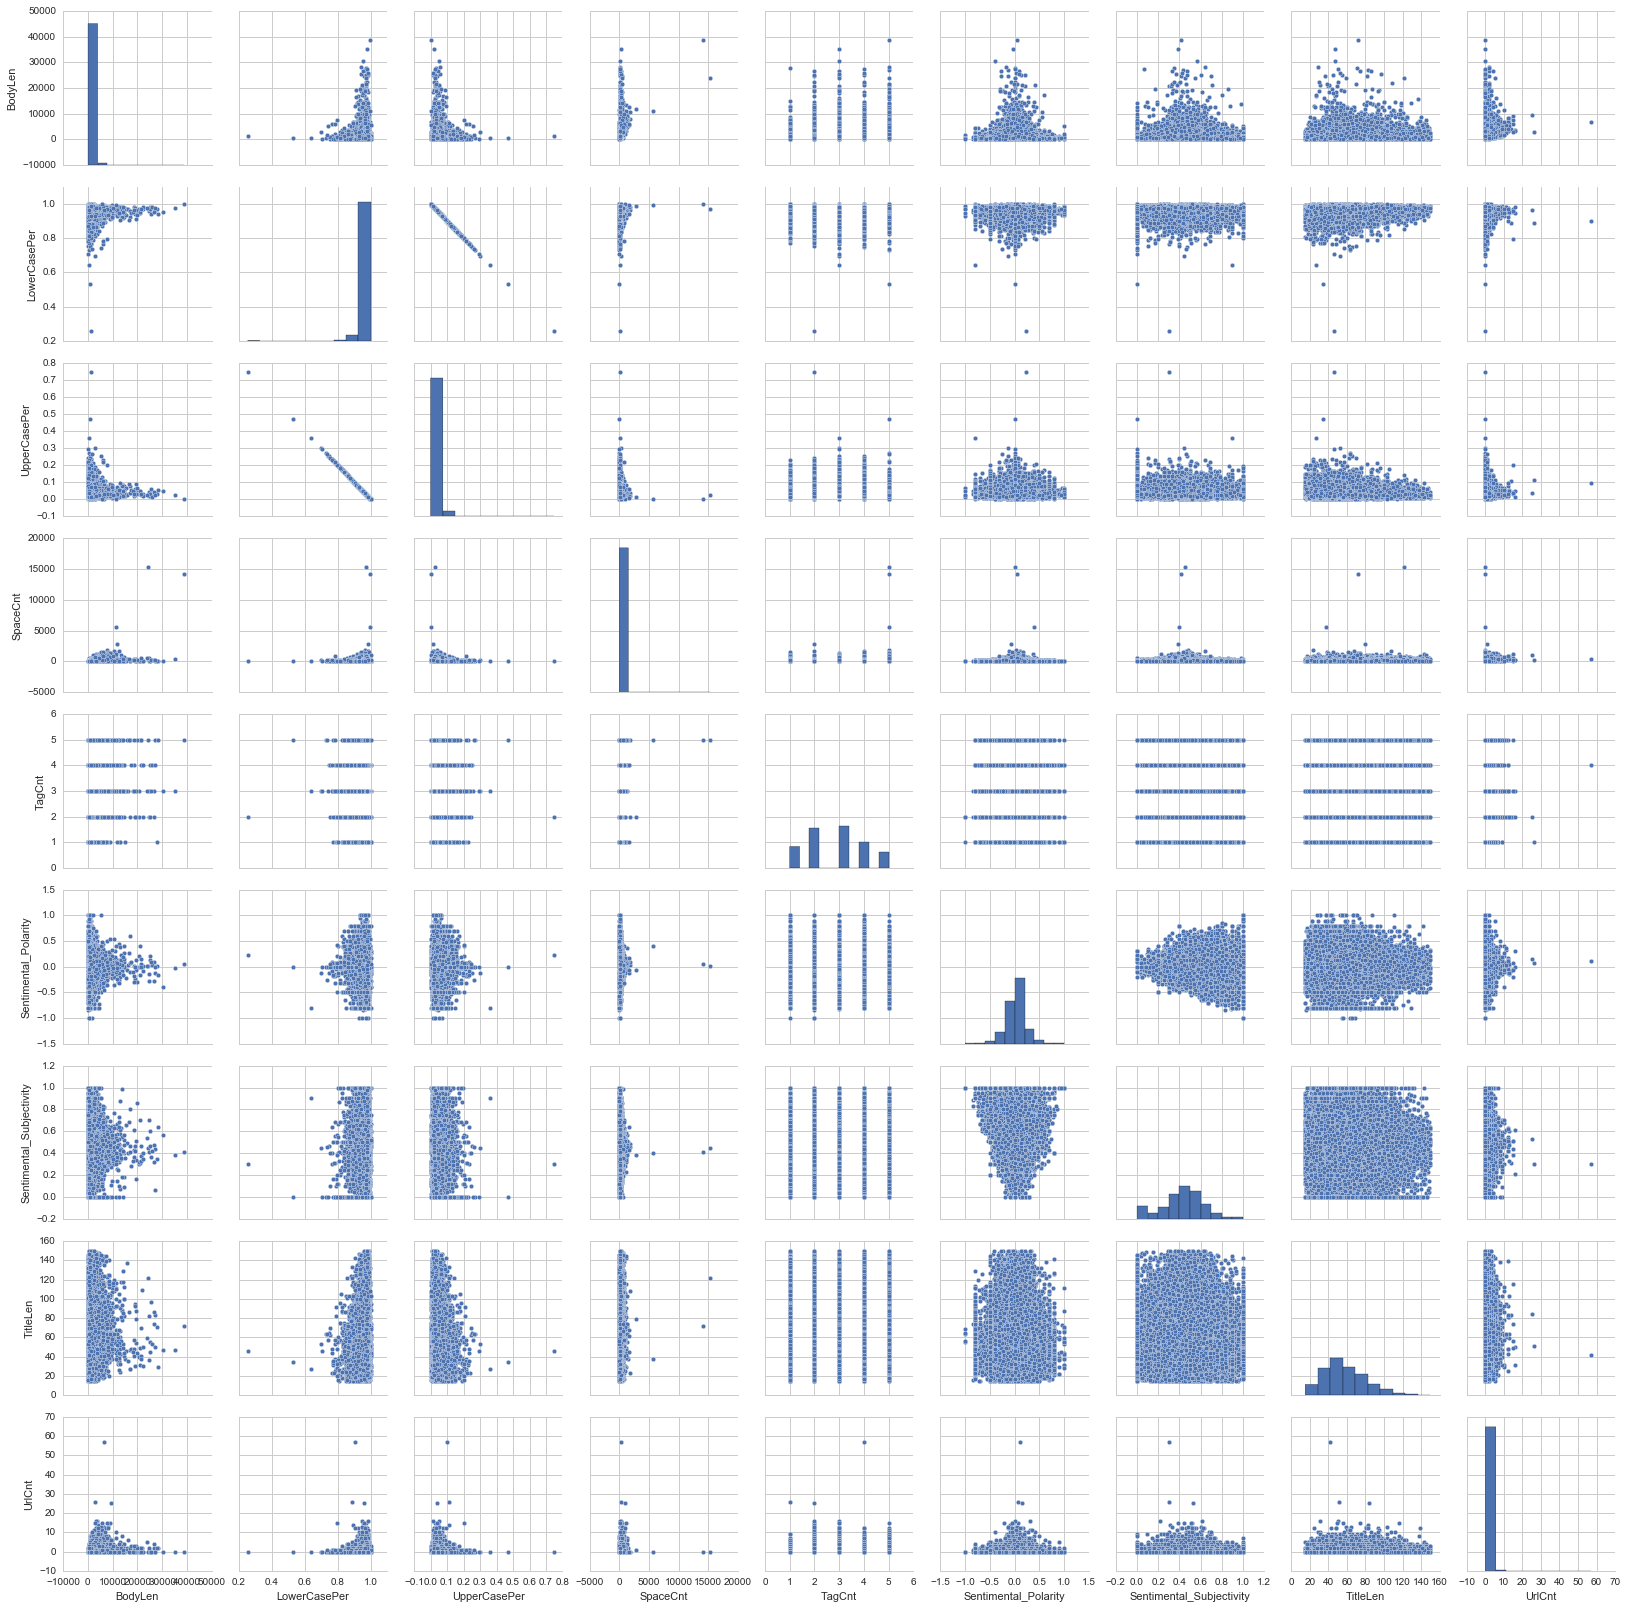

In [7]:
sns.pairplot(SOM[predictors_SOM].drop('Id',1).replace('NA', np.nan).dropna(axis=0, how='any'))

## Readability Metrics

In [8]:
RM.head()

,Id,Code number,formula,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per,Score
0,1,0.0,0.0,13,1,10.41,13.15,9.45,50.47,5.2,0.00613826,0.0,31
1,2,0.0,0.0,23,2,6.65,9.11,10.96,37,4.6,0.0036979,0.0,26
2,3,0.0,0.0,29,1,18.55,14.58,18.51,14.03,11.6,0.00275086,0.0,63
3,4,0.0,0.0,81,5,9.04,9.94,10.98,45.21,6.48,0.00110337,0.0,15
5,6,0.0,0.0,180,7,16.76,14.27,16.27,24.23,10.29,0.000372775,0.0,226


In [9]:
RM.shape

(75067, 13)

In [11]:
predictors_RM = [x for x in RM.columns if x not in ['Body','Score']]

In [12]:
RM[predictors_RM].head()

,Id,Code number,formula,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per
0,1,0.0,0.0,13,1,10.41,13.15,9.45,50.47,5.2,0.00613826,0.0
1,2,0.0,0.0,23,2,6.65,9.11,10.96,37,4.6,0.0036979,0.0
2,3,0.0,0.0,29,1,18.55,14.58,18.51,14.03,11.6,0.00275086,0.0
3,4,0.0,0.0,81,5,9.04,9.94,10.98,45.21,6.48,0.00110337,0.0
5,6,0.0,0.0,180,7,16.76,14.27,16.27,24.23,10.29,0.000372775,0.0


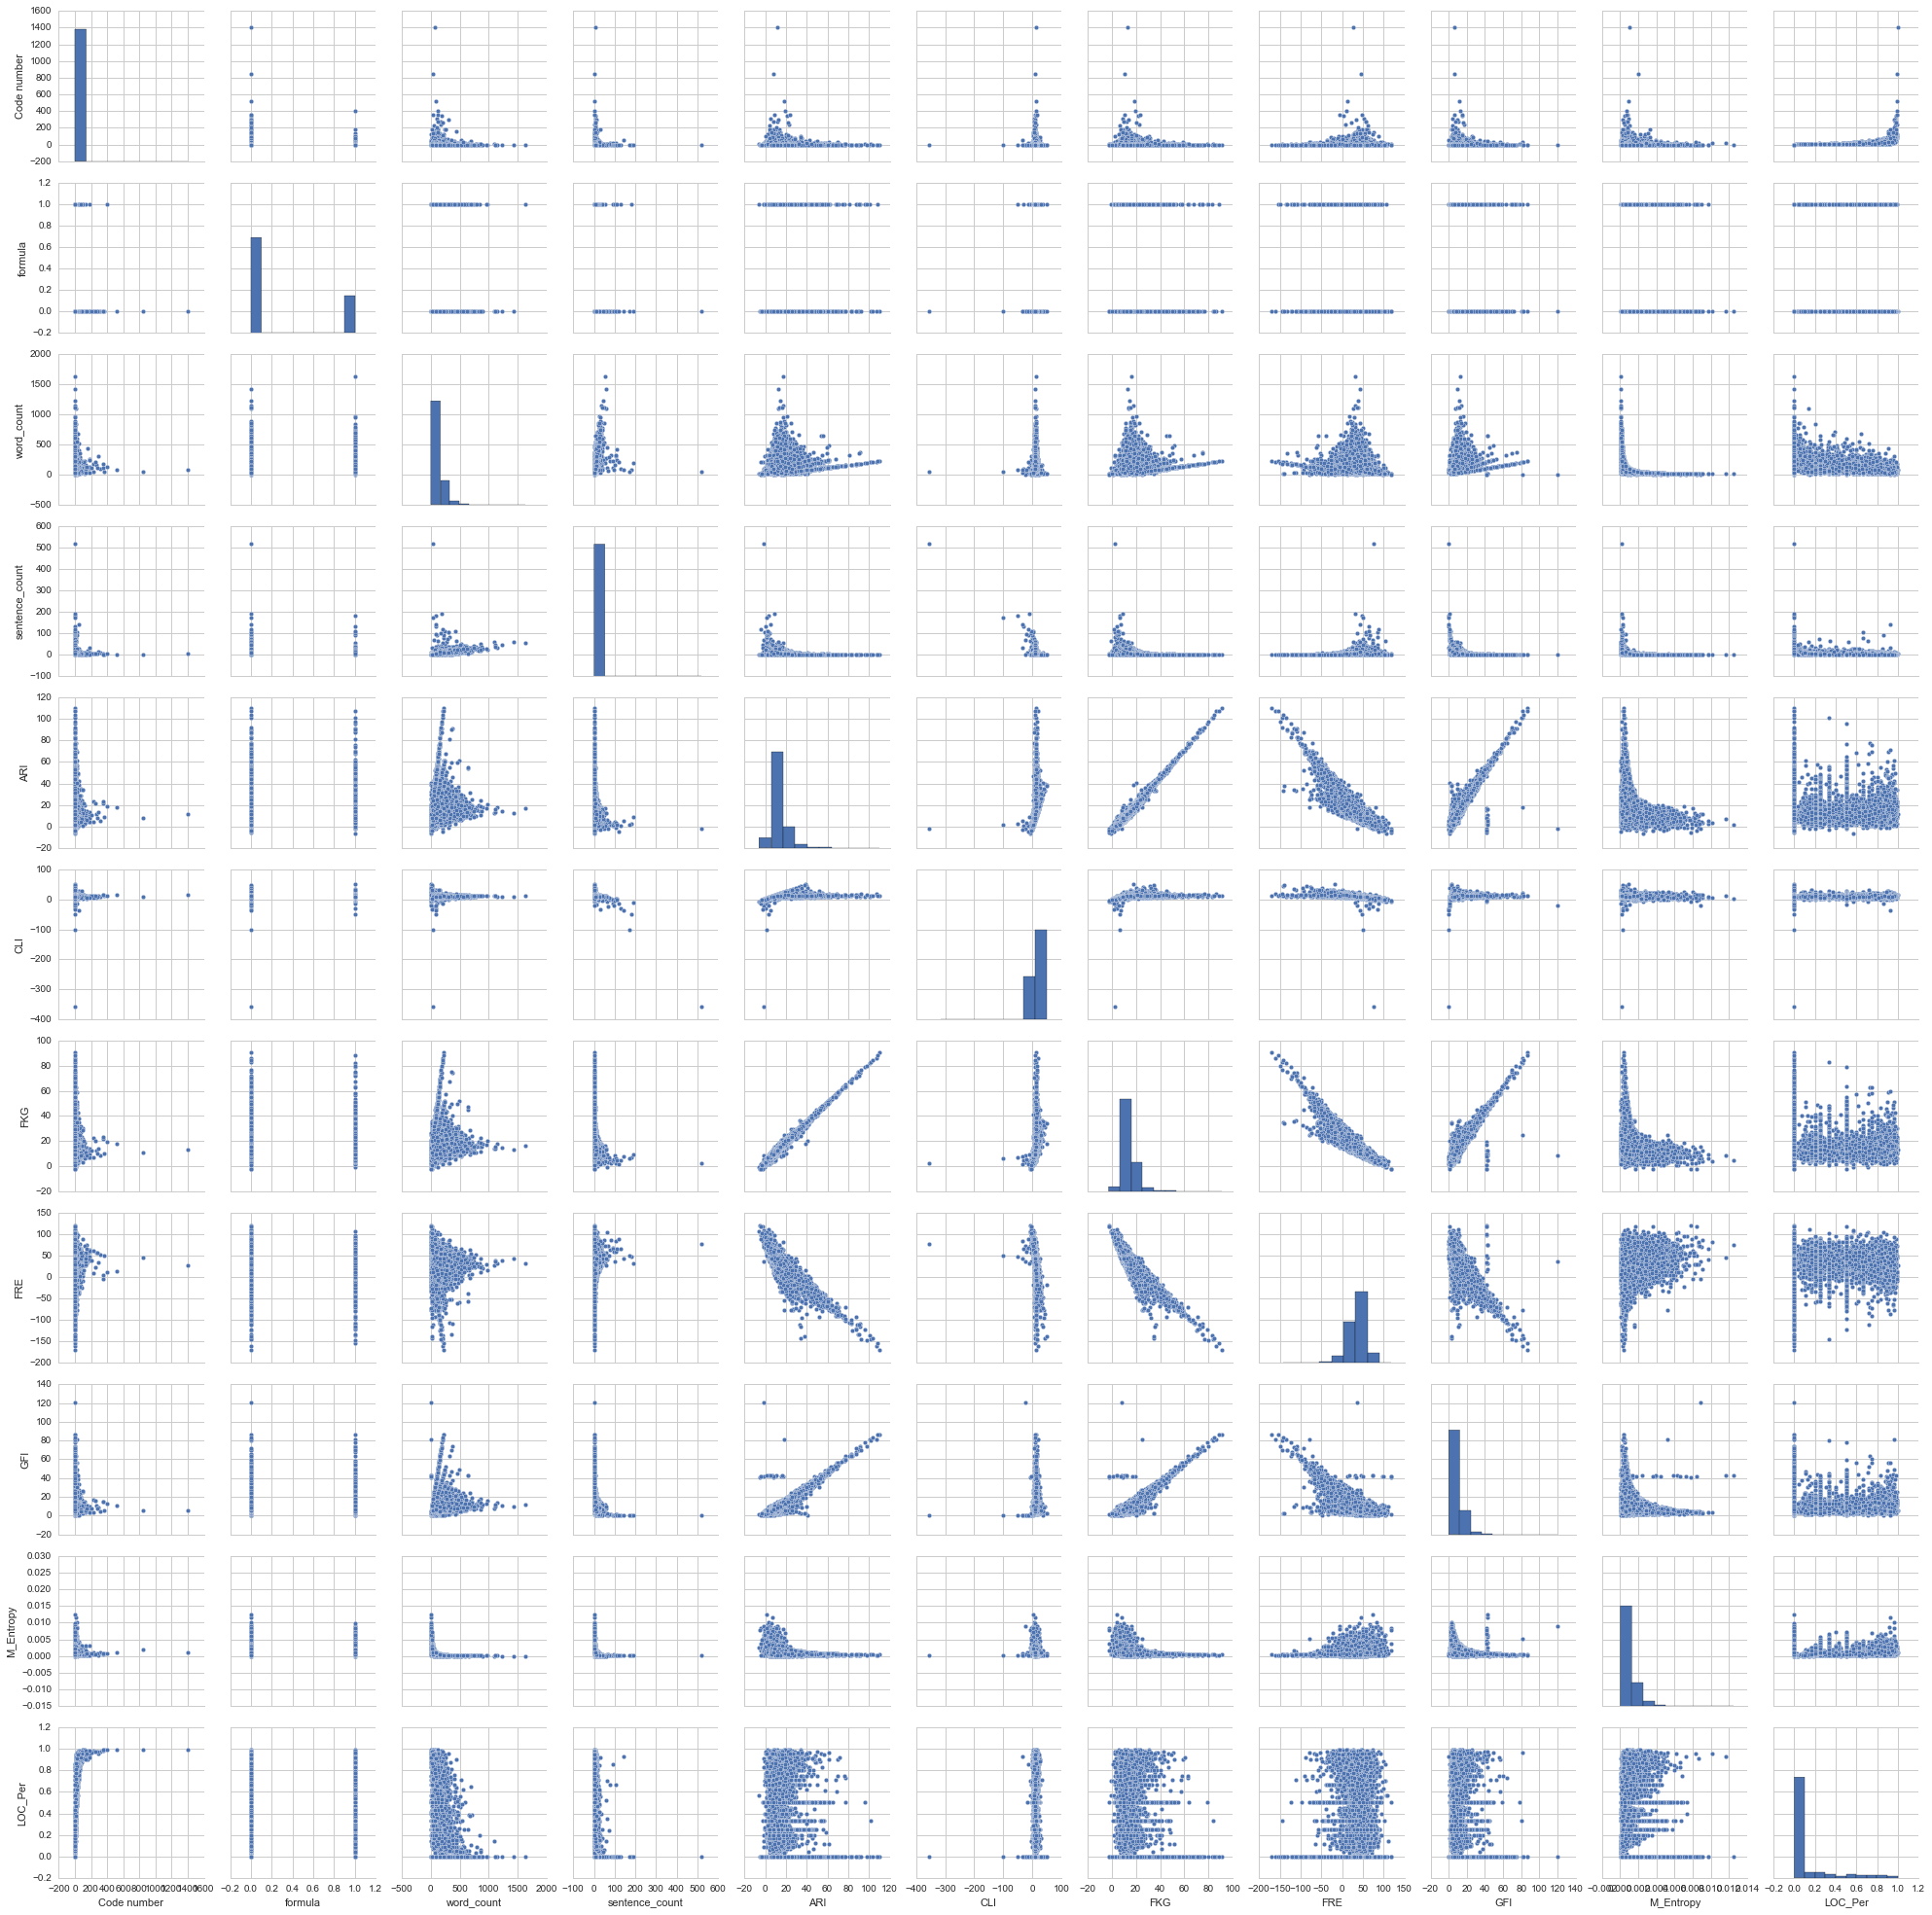

In [13]:
sns.pairplot(RM[predictors_RM].drop('Id',1).replace('NaN', np.nan).dropna(axis=0, how='any'))

## Popularity Metrics

In [14]:
PM.head()

,Id,CreationDate,OwnerUserId,AccpAnsCnt,AppEditCnt,BadgeCnt,CloDelVCnt,UpVoteCnt,DownVoteCnt,FavVoteCnt,Score
0,1,2010-07-19 19:12:12.510,8.0,0,0,0,0,0,0,0,31
1,2,2010-07-19 19:12:57.157,24.0,0,0,0,0,0,0,0,26
2,3,2010-07-19 19:13:28.577,18.0,0,0,0,0,0,0,0,63
3,4,2010-07-19 19:13:31.617,23.0,0,0,0,0,0,0,0,15
4,6,2010-07-19 19:14:44.080,5.0,0,0,0,0,0,0,0,226


In [15]:
PM.shape

(75067, 11)

In [16]:
predictors_PM = [x for x in PM.columns if x not in ['CreationDate','OwnerUserId','Score']]
target = 'Score'

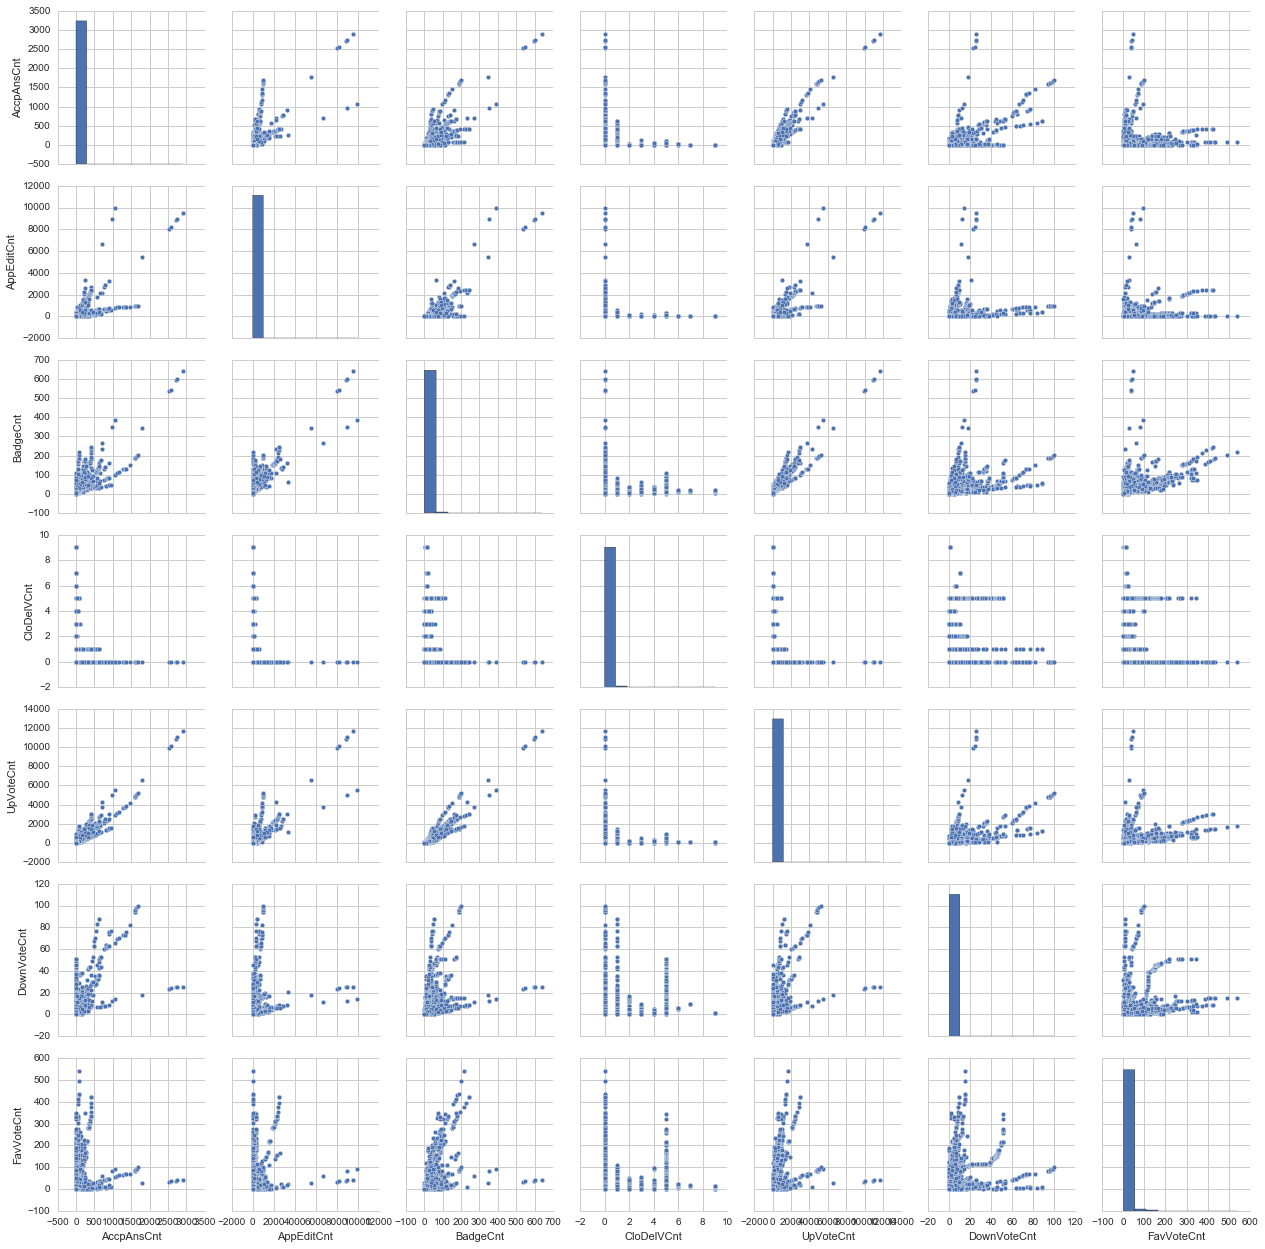

In [17]:
sns.pairplot(PM[predictors_PM].drop('Id',1))

In [18]:
dfs = [SOM[predictors_SOM],RM[predictors_RM],PM[predictors_PM],PM[['Id','Score']]]
data_SOQ = reduce(lambda left,right: pd.merge(left,right,on='Id'), dfs)

In [19]:
data_SOQ.shape, data_SOQ.columns

((75067, 29), Index([                      u'Id',                  u'BodyLen',
                    u'LowerCasePer',             u'UpperCasePer',
                        u'SpaceCnt',                   u'TagCnt',
            u'Sentimental_Polarity', u'Sentimental_Subjectivity',
                        u'TitleLen',                   u'UrlCnt',
                     u'Code number',                  u'formula',
                      u'word_count',           u'sentence_count',
                             u'ARI',                      u'CLI',
                             u'FKG',                      u'FRE',
                             u'GFI',                u'M_Entropy',
                         u'LOC_Per',               u'AccpAnsCnt',
                      u'AppEditCnt',                 u'BadgeCnt',
                      u'CloDelVCnt',                u'UpVoteCnt',
                     u'DownVoteCnt',               u'FavVoteCnt',
                           u'Score'],
       dtype='object'))

In [20]:
Class = []
def identify_class(row):
    if (row['Score']>=6) & (row['ClosedDate'] is None):
        Class.append(0)
    elif (row['Score']>=1) & (row['Score']<=5) & (row['ClosedDate']is None):
        Class.append(1)
    elif (row['Score']==0) & (row['ClosedDate']is None):
        Class.append(2)
    elif (row['Score']<0) & (row['ClosedDate']is None):
        Class.append(3)
    elif (row['ClosedDate']is not None):
        Class.append(4)

In [21]:
data_SOQ_class = qpost_df.apply(identify_class,axis=1)

In [22]:
Class_df = pd.Series(data=Class)
data_SOQ['Class'] = Class_df
data_SOQ['Class'].value_counts()

1    42336
2    21598
0     6933
4     3672
3      528
Name: Class, dtype: int64

In [23]:
Class_char = pd.Categorical.from_codes(data_SOQ['Class'], ['A','B','C','D','E'])
data_SOQ['Class_char'] = Class_char
data_SOQ=data_SOQ.replace('NA', np.nan)
data_SOQ=data_SOQ.replace('NaN', np.nan)
data_SOQ_rna = data_SOQ.dropna(axis=0, how='any')

In [24]:
data_SOQ.head(n=10)
target = 'Score'
Predictors = [x for x in data_SOQ.columns if x not in ['Id','Score','Class_char','Class']]
Predictors 

[u'BodyLen',
 u'LowerCasePer',
 u'UpperCasePer',
 u'SpaceCnt',
 u'TagCnt',
 u'Sentimental_Polarity',
 u'Sentimental_Subjectivity',
 u'TitleLen',
 u'UrlCnt',
 'Code number',
 'formula',
 'word_count',
 'sentence_count',
 'ARI',
 'CLI',
 'FKG',
 'FRE',
 'GFI',
 'M_Entropy',
 'LOC_Per',
 'AccpAnsCnt',
 'AppEditCnt',
 'BadgeCnt',
 'CloDelVCnt',
 'UpVoteCnt',
 'DownVoteCnt',
 'FavVoteCnt']

In [25]:
import pickle
with open('data_SOQ_rna.pickle', 'wb') as handle:
    pickle.dump(data_SOQ_rna, handle,protocol=2)

In [26]:
data_SOQ_rna=pd.read_pickle('data_SOQ_rna.pickle')

In [27]:
data_SOQ_rna[Predictors].shape

(30772, 27)

# Modeling-- Random Forest

In [28]:
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_SOQ_rna, data_SOQ_rna['Class'], test_size=0.3,random_state=1,stratify=data_SOQ_rna['Class'])

In [29]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((21540, 31), (9232, 31), (21540,), (9232,))

In [30]:
train_y.value_counts(),  test_y.value_counts()

(1    13768
 0     3564
 2     3165
 4      865
 3      178
 Name: Class, dtype: int64, 1    5901
 0    1527
 2    1356
 4     371
 3      77
 Name: Class, dtype: int64)

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
param_grid = { 
    'n_estimators': range(200,1100,100),
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_clf.fit(train_x[Predictors], train_y)
CV_clf.grid_scores_, CV_clf.best_params_, CV_clf.best_score_

([mean: 0.63993, std: 0.00218, params: {'max_features': 'auto', 'n_estimators': 200},
  mean: 0.64011, std: 0.00207, params: {'max_features': 'auto', 'n_estimators': 300},
  mean: 0.64085, std: 0.00254, params: {'max_features': 'auto', 'n_estimators': 400},
  mean: 0.64025, std: 0.00250, params: {'max_features': 'auto', 'n_estimators': 500},
  mean: 0.64011, std: 0.00280, params: {'max_features': 'auto', 'n_estimators': 600},
  mean: 0.64002, std: 0.00289, params: {'max_features': 'auto', 'n_estimators': 700},
  mean: 0.64002, std: 0.00308, params: {'max_features': 'auto', 'n_estimators': 800},
  mean: 0.64006, std: 0.00318, params: {'max_features': 'auto', 'n_estimators': 900},
  mean: 0.63965, std: 0.00290, params: {'max_features': 'auto', 'n_estimators': 1000},
  mean: 0.63993, std: 0.00218, params: {'max_features': 'sqrt', 'n_estimators': 200},
  mean: 0.64011, std: 0.00207, params: {'max_features': 'sqrt', 'n_estimators': 300},
  mean: 0.64085, std: 0.00254, params: {'max_features

In [58]:
clf = RandomForestClassifier(n_estimators=400,n_jobs=-1,random_state=1,oob_score = True)

In [59]:
clf.fit(train_x[Predictors], train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [60]:
clf.oob_score_, clf.feature_importances_

(0.63946146703806872,
 array([ 0.05723104,  0.05582735,  0.05568541,  0.05055988,  0.02428161,
         0.0560202 ,  0.0549506 ,  0.05704496,  0.01070416,  0.01581255,
         0.00943059,  0.04996469,  0.02494834,  0.05350959,  0.05963862,
         0.05292262,  0.05590162,  0.05265985,  0.05722232,  0.01848481,
         0.01979663,  0.02139177,  0.02552976,  0.00305117,  0.03101926,
         0.00886351,  0.0175471 ]))

In [61]:
preds = clf.predict(test_x[Predictors])
metrics.accuracy_score(test_y, preds),
#print('ROC: %.2f' % (metrics.roc_auc_score(test_y, preds)))

(0.63886481802426343,)

In [62]:
pd.crosstab(test_y, preds, rownames=['actual'], colnames=['preds'])

preds,0,1,2,4
actual,,,,
0,60,1465,2,0
1,57,5832,11,1
2,3,1347,6,0
3,0,77,0,0
4,10,361,0,0


In [63]:
def plot_featureimportance(model_feature):
    feature_importance = pd.DataFrame(model_feature, index = Predictors)
    feature_importance = feature_importance.sort(0,ascending=False)
    #plt.figure(figsize=(10, 8))
    feature_importance.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')
    plt.show()

/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


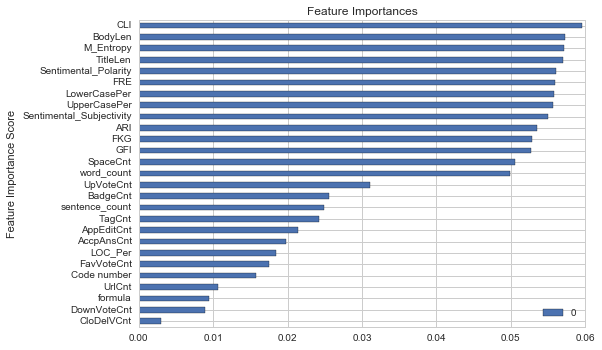

In [64]:
plot_featureimportance(clf.feature_importances_)

## Extreme Gradient Boosting

### Step 1- Find the number of estimators for a high learning rate

In [44]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [45]:
train = train_x
train['Score'] = train_y
test = test_x
test['Score'] = test_y

/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
train.shape, test.shape

((21540, 31), (9232, 31))

In [47]:
def modelfit(alg, dtrain, dtest, predictors,target, useTrainCV=True, cv_folds=5, early_stopping_round=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        xgb_param_forcv = xgb_param
        xgb_param_forcv['num_class'] = 5
        cvresult = xgb.cv(xgb_param_forcv, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_round, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='merror')
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    return alg, dtrain_predictions
   

In [48]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb1, dtrain_predictions = modelfit(xgb1, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-merror:0.362906+0.00810594789028	cv-train-merror:0.3532264+0.00231090351162
[1]	cv-test-merror:0.3618852+0.00802104395699	cv-train-merror:0.3534354+0.00166347330607
[2]	cv-test-merror:0.3613276+0.00885702174774	cv-train-merror:0.3530642+0.00147533879499
[3]	cv-test-merror:0.3611422+0.00904786996812	cv-train-merror:0.3530988+0.00132453001476
[4]	cv-test-merror:0.3607244+0.00914835260798	cv-train-merror:0.352739+0.0016077129097
[5]	cv-test-merror:0.360492+0.00911620063404	cv-train-merror:0.3525418+0.00138396869907
[6]	cv-test-merror:0.35961+0.00898695016121	cv-train-merror:0.3524258+0.00145093589107
[7]	cv-test-merror:0.3592386+0.00946507100026	cv-train-merror:0.3526114+0.00104564785659
[8]	cv-test-merror:0.3591458+0.00913240470851	cv-train-merror:0.3523562+0.00125293725302
[9]	cv-test-merror:0.3593316+0.00872472868575	cv-train-merror:0.3521006+0.00115876962335
[10]	cv-test-merror:0.3596564+0.00907568722687	cv-train-mer

In [52]:
def get_performance(xgbmodel,dtrain,dtest,predictors,dtrain_predictions):
    print "\nModel Report"
    print "Train accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    test_result = xgbmodel.predict(dtest[predictors])
    print "Test accuracy : %.4g" % metrics.accuracy_score(dtest[target].values, test_result)
    print pd.crosstab(dtest[target].values, test_result, rownames=['actual'], colnames=['preds'])
    feat_imp = pd.Series(xgbmodel.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')


Model Report
Train accuracy : 0.6486
Test accuracy : 0.6398
preds    0     1  4
actual             
0       37  1490  0
1       31  5869  1
2        0  1356  0
3        0    77  0
4        4   366  1


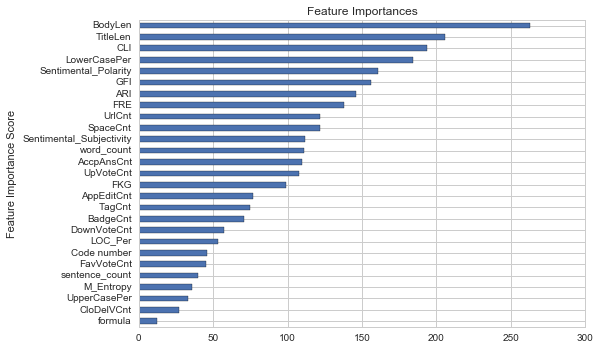

In [53]:
get_performance(xgb1,train,test,Predictors,dtrain_predictions)

### Hyperparameter Tuning
### Step 2: Tune max_depth and min_child_weight

In [66]:
param_test1 = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=21, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[Predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.63937, std: 0.00101, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.63946, std: 0.00093, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.63960, std: 0.00083, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.63951, std: 0.00087, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.63928, std: 0.00058, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.64002, std: 0.00145, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.64016, std: 0.00164, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.63983, std: 0.00213, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.64002, std: 0.00171, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.63983, std: 0.00162, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.64034, std: 0.00215, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.64090, std: 0.00211, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.64090, std: 0.00211, params: {

In [69]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=8,
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb2, dtrain_predictions = modelfit(xgb2, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-merror:0.3728414+0.00705201150311	cv-train-merror:0.3394496+0.00152789981347
[1]	cv-test-merror:0.3640206+0.00899901020335	cv-train-merror:0.3394846+0.00174676049875
[2]	cv-test-merror:0.3623026+0.00773973592831	cv-train-merror:0.3398212+0.00165018912855
[3]	cv-test-merror:0.3619778+0.00805255073626	cv-train-merror:0.3393684+0.00152431959903
[4]	cv-test-merror:0.3604922+0.00722668525397	cv-train-merror:0.3389856+0.00178775172773
[5]	cv-test-merror:0.3603994+0.00786828582602	cv-train-merror:0.3382776+0.00156915398862
[6]	cv-test-merror:0.3597956+0.00822257051292	cv-train-merror:0.3377322+0.00144533683271
[7]	cv-test-merror:0.3600278+0.00850738367302	cv-train-merror:0.337593+0.00153658478451
[8]	cv-test-merror:0.359703+0.00867488660445	cv-train-merror:0.3370704+0.00169496685513
[9]	cv-test-merror:0.3595634+0.00811038402543	cv-train-merror:0.3363742+0.00131732902496
[10]	cv-test-merror:0.35961+0.00797169951767	cv-train-m


Model Report
Train accuracy : 0.6857
Test accuracy : 0.6394
preds    0     1  2  4
actual                
0       70  1455  2  0
1       68  5829  4  0
2        0  1353  3  0
3        0    77  0  0
4        9   361  0  1


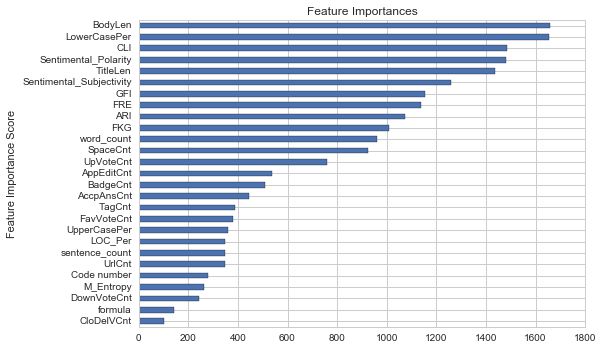

In [70]:
get_performance(xgb2,train,test,Predictors,dtrain_predictions)

## Step 3: Tune gamma

In [71]:
xgb2

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=40, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [73]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,6)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[Predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.64192, std: 0.00291, params: {'gamma': 0.0},
  mean: 0.64058, std: 0.00160, params: {'gamma': 0.1},
  mean: 0.64155, std: 0.00297, params: {'gamma': 0.2},
  mean: 0.64095, std: 0.00284, params: {'gamma': 0.3},
  mean: 0.64062, std: 0.00193, params: {'gamma': 0.4},
  mean: 0.64090, std: 0.00148, params: {'gamma': 0.5}],
 {'gamma': 0.0},
 0.64192252437718955)

## Step 4: Tune subsample and colsample_bytree

In [74]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[Predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.64071, std: 0.00108, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.63983, std: 0.00184, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.63983, std: 0.00221, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.64006, std: 0.00210, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.64099, std: 0.00169, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.64002, std: 0.00164, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.64062, std: 0.00242, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.64011, std: 0.00201, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.64053, std: 0.00120, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.63988, std: 0.00266, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.64192, std: 0.00291, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.64076, std: 0.00117, params: {'subsample': 0.9, 'colsample_bytree'

## Step 5: Tuning Regularization Parameters

In [76]:
param_test4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=40, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test4, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[Predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.64192, std: 0.00291, params: {'reg_alpha': 0},
  mean: 0.64146, std: 0.00294, params: {'reg_alpha': 0.001},
  mean: 0.64076, std: 0.00154, params: {'reg_alpha': 0.005},
  mean: 0.64085, std: 0.00218, params: {'reg_alpha': 0.01},
  mean: 0.64132, std: 0.00206, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0},
 0.64192252437718955)